# Demo of `BaselineClassifier` Class and its Methods

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-libraries-and-data" data-toc-modified-id="Load-libraries-and-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load libraries and data</a></span><ul class="toc-item"><li><span><a href="#Check-dataframe-structure" data-toc-modified-id="Check-dataframe-structure-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Check dataframe structure</a></span></li><li><span><a href="#Prepare-data" data-toc-modified-id="Prepare-data-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Prepare data</a></span></li></ul></li><li><span><a href="#Initialize-the-models" data-toc-modified-id="Initialize-the-models-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Initialize the models</a></span></li><li><span><a href="#Use-the-function-go_quickDirty-for-one-step-logistic-regression-modelling" data-toc-modified-id="Use-the-function-go_quickDirty-for-one-step-logistic-regression-modelling-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Use the function <code>go_quickDirty</code> for one-step logistic regression modelling</a></span><ul class="toc-item"><li><span><a href="#Compare-to-Naive-Baseline" data-toc-modified-id="Compare-to-Naive-Baseline-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Compare to Naive Baseline</a></span></li><li><span><a href="#Evaluate-the-model-in-more-detail" data-toc-modified-id="Evaluate-the-model-in-more-detail-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Evaluate the model in more detail</a></span></li></ul></li><li><span><a href="#Use-the-function-go_quickDirty-for-one-step-tree-based-modelling" data-toc-modified-id="Use-the-function-go_quickDirty-for-one-step-tree-based-modelling-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Use the function <code>go_quickDirty</code> for one-step tree-based modelling</a></span><ul class="toc-item"><li><span><a href="#Examine-feature-weights" data-toc-modified-id="Examine-feature-weights-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Examine feature weights</a></span></li></ul></li></ul></div>

## Load libraries and data

In [1]:
import numpy as np
import pandas as pd

import EDA_functions, cleaning_functions
from baseline_classifier import BaselineClassification

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import log_loss, f1_score, confusion_matrix, \
    classification_report
from sklearn.utils import resample  # for error calculation of feature weights

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

# display all columns in df
from IPython.display import display
pd.options.display.max_columns = None

In [2]:
titanic = pd.read_csv('../data/train_titanic.csv')

### Check dataframe structure
(For real projects some of the steps below should only be performed after separating the test set)

In [3]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [4]:
titanic.sample(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
858,859,1,3,"Baclini, Mrs. Solomon (Latifa Qurban)",female,24.0,0,3,2666,19.2583,NaN,C
538,539,0,3,"Risien, Mr. Samuel Beard",male,NaN,0,0,364498,14.5000,NaN,S
747,748,1,2,"Sinkkonen, Miss. Anna",female,30.0,0,0,250648,13.0000,NaN,S


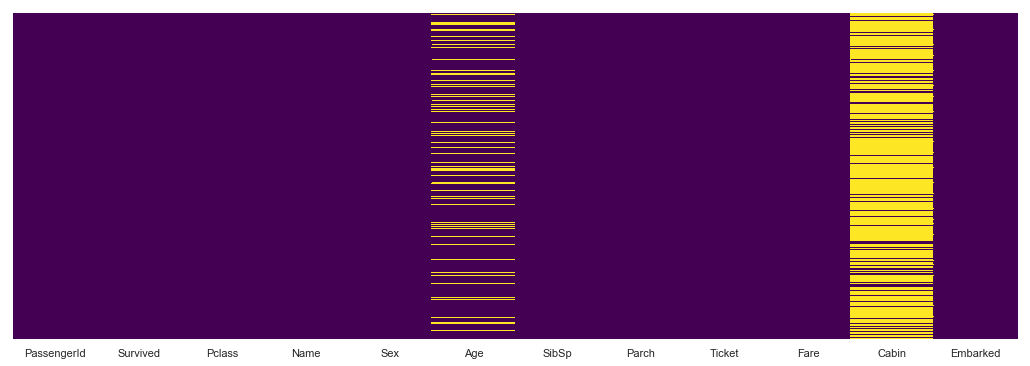

In [5]:
cleaning_functions.plot_NaN(titanic)

In [6]:
cleaning_functions.list_NaN(titanic)

,total,percent,dtype
Cabin,687,77.1,object
Age,177,19.9,float64
Embarked,2,0.2,object


In [7]:
for col in ['SibSp', 'Parch']:
    print(titanic[col].value_counts())

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64
0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64


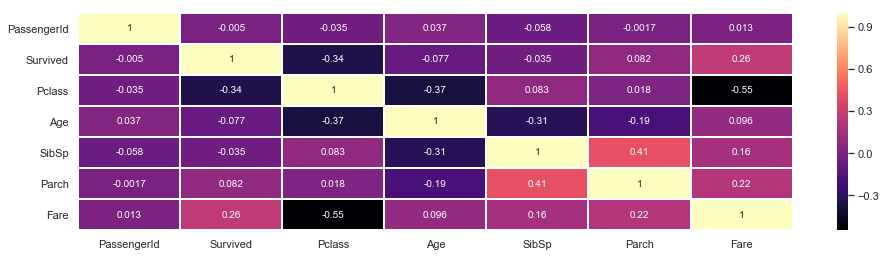

In [8]:
EDA_functions.plot_corr_map_num_all(titanic, figsize=(16,4))

**Need for cleaning:**
- cols_to_drop = ['PassengerId', 'Name', 'Ticket', 'Cabin']
- cols_to_cat = ['Sex', 'Parch', 'SibSp', 'Embarked']
    

### Prepare data

In [9]:
cols_to_drop = ['PassengerId', 'Name', 'Ticket', 'Cabin']
cols_to_cat = ['Sex', 'Parch', 'SibSp', 'Embarked']

titanic = cleaning_functions.change_dtypes(titanic, cols_to_category=cols_to_cat)
titanic = cleaning_functions.delete_columns(titanic, cols_to_delete=cols_to_drop)

PassengerId successfully deleted
Name successfully deleted
Ticket successfully deleted
Cabin successfully deleted


In [10]:
# Check results
display(titanic.head())
print(titanic.info())

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Sex         891 non-null category
Age         714 non-null float64
SibSp       891 non-null category
Parch       891 non-null category
Fare        891 non-null float64
Embarked    889 non-null category
dtypes: category(4), float64(2), int64(2)
memory usage: 32.3 KB
None


## Initialize the models

First step is to initialize a (or a couple of different) linear scikit-learn model object with it's correspoding parameters. 

In [11]:
"Logistic regression model"

# Define a scikit-learn model object you want to work with
model_lin = LogisticRegression(solver='liblinear')
# Create an instance of the LinRegModel class by passing the dataframe, the target variable and the model object
logReg_simple = BaselineClassification(titanic, 'Survived', model_lin)

In [12]:
# You can output the model with help of the instance variable name
logReg_simple

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [13]:
"Random Forest model"

# Define a scikit-learn model object you want to work with
model_rf = RandomForestClassifier(n_estimators=30)
# Create an instance of the LinRegModel class by passing the dataframe, the target variable and the model object
rf_simple = BaselineClassification(titanic, 'Survived', model_rf)

In [14]:
# You can output the model with help of the instance variable name
rf_simple

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [15]:
"Gradient Boosting model"

# Define a scikit-learn model object you want to work with
model_gbc = GradientBoostingClassifier(n_estimators=100)
# Create an instance of the LinRegModel class by passing the dataframe, the target variable and the model object
gbc_simple = BaselineClassification(titanic, 'Survived', model_gbc)

In [16]:
# You can output the model with help of the instance variable name
gbc_simple

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

## Use the function `go_quickDirty` for one-step logistic regression modelling

`go_quickDirty` is a method of the BaselineClassification class for preprocessing data, fitting and testing a classification model _in one step_. You can pass (almost) any unprepared data. (It is called quick & dirty because the preprocessing is quite unsophisticated: NA values will be  handled in a simple way, categorical variables dummied. But there is no outlier treatment or scaling.)

Details on preprocessing for non-tree-based models:
- All columns with dtype object and category will be one-hot-encoded. (Make sure they all have categorical character.)
- All NaN in numerical cols will be imputed with mean, all NaN in non-numerical columns will be dummied (for mixing into the zero category, change the 'dummy_na' parameter)

In [17]:
# Perform linear regression modelling on instance
logReg_simple.go_quickDirty(tree_based=False, transform=False)

LogisticRegression

ROC AUC: 0.8518
precision_score: 0.8021
recall_score: 0.7064
f1_score: 0.7512


For an imbalanced classification problem, there are a number of **metrics** to consider:
- _Receiver Operating Characteristic Area Under the Curve (ROC AUC):_ A measure between 0 and 1 comparing the performance of the classifier when predicting probabilities across a range of thresholds.
- _Precision Score:_ number of true positives divided by the total number of positives predicted
- _Recall Score:_ number of true positives divided by the total number of actual positives in the data
- _F1 Score:_ Harmonic mean of precision and recall. (or _F-Beta score_ depending on business case, see automotive capstone.)

A brilliant [blogpost](https://medium.com/usf-msds/choosing-the-right-metric-for-evaluating-machine-learning-models-part-2-86d5649a5428) on classification metrics can be found here.

### Compare to Naive Baseline

For a naive baseline, we can randomly guess that an instance is of the positive class in the same frequence of the positive classified instances in the training data. We'll assess the predictions using the same metrics as the proper baseline model.

In [18]:
logReg_simple.compare_to_naive()

Percentage of positive class in training data is: 0.374


Naive Baseline

ROC AUC: 0.5
precision_score: 0.4414
recall_score: 0.4495
f1_score: 0.4455


### Evaluate the model in more detail

[learning_curve] Training set sizes: [  4  30  56  82 108 134 160 186 212 238 264 290 316 342 368 394 420 446
 472 498]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.8s finished


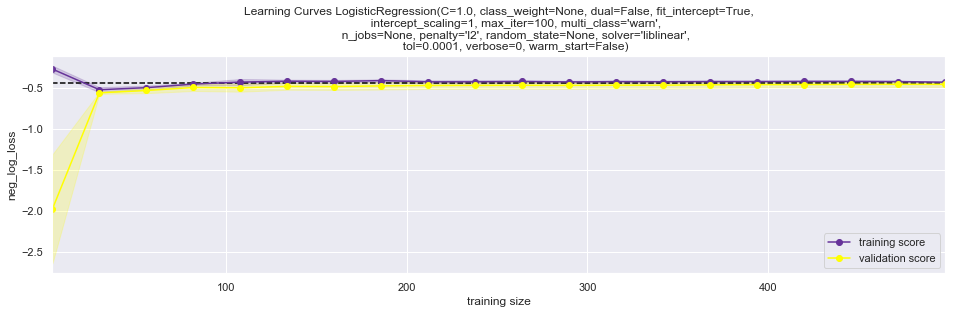

In [19]:
# Plot learning curves using 5-fold cross validation
logReg_simple.plot_learning_curves()

In [20]:
logReg_simple.print_classification_report()

              precision    recall  f1-score   support

           0       0.81      0.88      0.85       159
           1       0.80      0.71      0.75       109

   micro avg       0.81      0.81      0.81       268
   macro avg       0.81      0.79      0.80       268
weighted avg       0.81      0.81      0.81       268



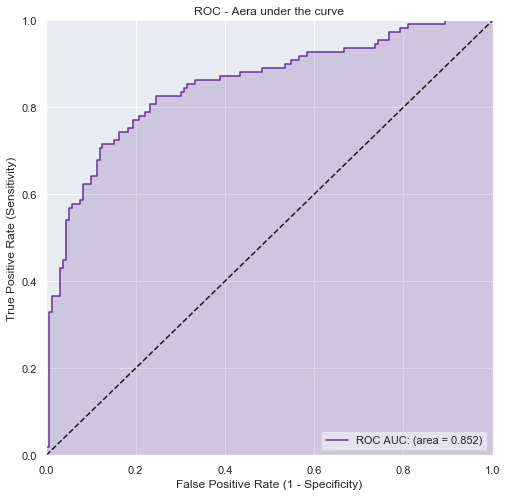

In [21]:
logReg_simple.plot_ROC_curve()

True positives: 77 (28.73%)
False positives: 19 (7.09%)
True negatives: 140 (52.24%)
False negatives: 32 (11.94%)

Proportion of misclassified instances in total: 0.19
Typ I error (Number of items wrongly identified as positive out of total true negatives): 0.12
Type II error (Number of items wrongly identified as negative out of total true positives): 0.29


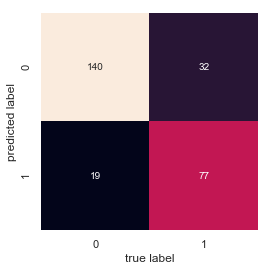

In [22]:
logReg_simple.plot_confusion_matrix()

In [23]:
# Plot feature weights (error estimation by bootstrapping)
logReg_simple.print_coef_weights(n_bootstrap=5)

,effect,error
Sex_male,-2.3,0.0
SibSp_3.0,-1.5,0.0
SibSp_8.0,-1.0,0.0
Parch_4.0,-0.9,0.0
SibSp_4.0,-0.9,0.0
Pclass,-0.8,0.0
Parch_5.0,-0.6,0.0
Parch_1.0,0.5,0.0
Parch_6.0,-0.4,1.0
Embarked_Q,0.3,0.0


,effect,error
category,,
SibSp,-3.1,0.0
Sex,-2.3,0.0
Parch,-1.3,1.0
Pclass,-0.8,0.0
Embarked,0.3,0.0
Age,0.0,0.0
Fare,0.0,0.0


***

## Use the function `go_quickDirty` for one-step tree-based modelling

In [24]:
# Run Random Forest
rf_simple.go_quickDirty(tree_based=True)

RandomForestClassifier

ROC AUC: 0.8646
precision_score: 0.8351
recall_score: 0.7431
f1_score: 0.7864


In [25]:
# Run Gradient Boosting
gbc_simple.go_quickDirty(tree_based=True)

GradientBoostingClassifier

ROC AUC: 0.8785
precision_score: 0.8916
recall_score: 0.6789
f1_score: 0.7708


### Examine feature weights

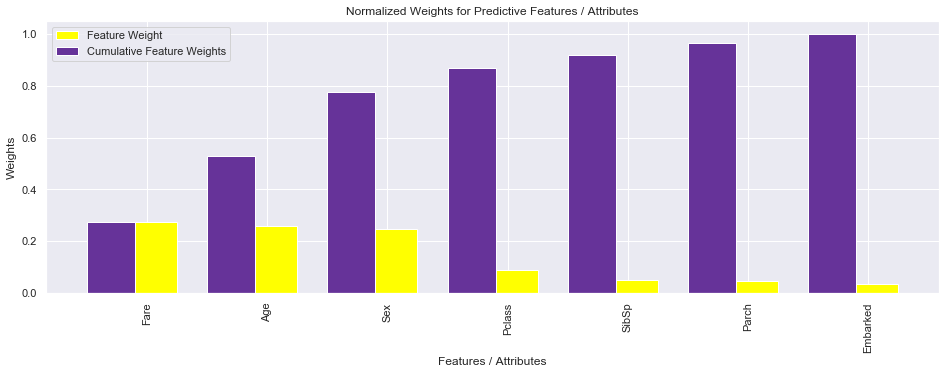

In [26]:
rf_simple.plot_feature_weights()

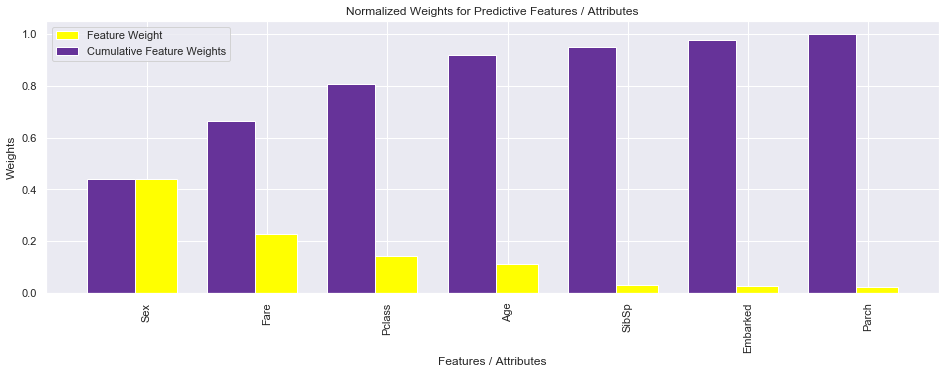

In [27]:
gbc_simple.plot_feature_weights()

---